#### **Use Grid Search to Find the most Informative Peaks**

Import Libraries

In [2]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from scipy.signal import peak_widths, peak_prominences
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate
from joblib import Parallel, delayed

Read the spectral data

In [3]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")
#df = pd.read_csv("../../data/current_clean_spectrum.csv", index_col=0)

In [4]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,0,200.00000,2709.3699,201210-1,Normal
1,201210-1-00,1,200.68336,2697.1318,201210-1,Normal
2,201210-1-00,2,201.36674,2696.0413,201210-1,Normal
3,201210-1-00,3,202.05011,2678.5925,201210-1,Normal
4,201210-1-00,4,202.73349,2670.8928,201210-1,Normal
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,1321.0371,210526-3,Hyperglycemia
8023571,210526-3-09,2631,1997.94980,1316.4056,210526-3,Hyperglycemia
8023572,210526-3-09,2632,1998.63330,1311.2640,210526-3,Hyperglycemia
8023573,210526-3-09,2633,1999.31670,1318.0909,210526-3,Hyperglycemia


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8023575 entries, 0 to 8023574
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SpecID      object 
 1   Seq         int64  
 2   WaveNumber  float64
 3   Absorbance  float64
 4   SurID       object 
 5   Status      object 
dtypes: float64(2), int64(1), object(3)
memory usage: 367.3+ MB


In [6]:
sample = df[df['SpecID'] == "210526-3-04"]
print(sample)

              SpecID   Seq  WaveNumber  Absorbance     SurID         Status
7981415  210526-3-04     0   200.00000   3094.2837  210526-3  Hyperglycemia
7981416  210526-3-04     1   200.68336   3109.5640  210526-3  Hyperglycemia
7981417  210526-3-04     2   201.36674   3041.8801  210526-3  Hyperglycemia
7981418  210526-3-04     3   202.05011   3033.1189  210526-3  Hyperglycemia
7981419  210526-3-04     4   202.73349   3061.7734  210526-3  Hyperglycemia
...              ...   ...         ...         ...       ...            ...
7984045  210526-3-04  2630  1997.26650   1646.8857  210526-3  Hyperglycemia
7984046  210526-3-04  2631  1997.94980   1655.2378  210526-3  Hyperglycemia
7984047  210526-3-04  2632  1998.63330   1652.1541  210526-3  Hyperglycemia
7984048  210526-3-04  2633  1999.31670   1644.7822  210526-3  Hyperglycemia
7984049  210526-3-04  2634  2000.00000   1638.7900  210526-3  Hyperglycemia

[2635 rows x 6 columns]


Find Peaks Within the spectrum.

In [7]:
#peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)
peaks, _ = find_peaks(x=sample['Absorbance'])

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

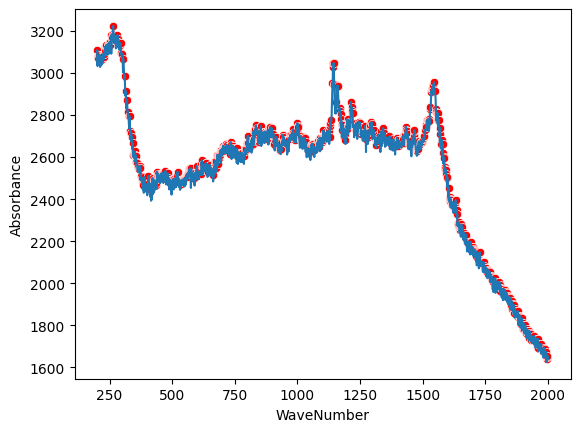

In [8]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[peaks], x="WaveNumber", y="Absorbance", color="red")

As you can see, it does not properly find the peaks, so we have to tune the peak finding parameters.

These parameters are based on Thomas Keogh's Search

In [9]:
tuned_peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

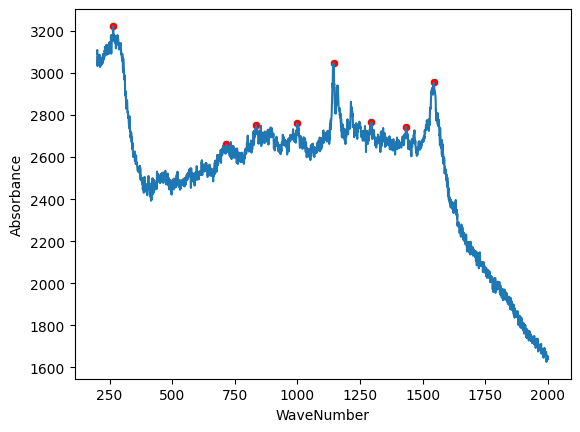

In [10]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[tuned_peaks], x="WaveNumber", y="Absorbance", color="red")

#### **Find the best Peak Finding Parameters**

Create a field for each wavelength.

Train an Extra Trees Classifier

In [11]:
def evaluate_extra_trees(df):
    # Splitting the dataframe into features (X) and target variable (y)
    X = df.drop(['Status'], axis=1)
    y = df['Status']
    
    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using StratifiedKFold for classification tasks
    #cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)

    
    # Getting cross-validation scores
    scores = cross_val_score(et, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

#### **1. Using Peak Statistics**

In [12]:
backup = df

In [13]:
statuses = df[['SpecID', 'Status']].drop_duplicates()

This uses statistical properties of the peaks in each sample to be used as additional features.

In [14]:
peaks = []
widths = []
prominences = []
areas = []

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    #peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42, width=6)
    peak_index, _ = find_peaks(x=group['Absorbance'])
    peak_index, _ = find_peaks(x=group['Absorbance'], distance=None, prominence=None, width=None)

    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences

/tmp/ipykernel_11221/1796515939.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
/tmp/ipykernel_11221/1796515939.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [15]:
peaks_df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PeakWidths,PeakProminences
7,201210-1-00,7,204.78360,2690.32400,201210-1,Normal,0.814277,43.99950
10,201210-1-00,10,206.83371,2639.71040,201210-1,Normal,1.441874,25.30900
13,201210-1-00,13,208.88382,2642.42430,201210-1,Normal,2.022615,33.41110
16,201210-1-00,16,210.93394,2614.35740,201210-1,Normal,0.718095,3.53680
21,201210-1-00,21,214.35080,2618.04910,201210-1,Normal,0.939650,23.74690
...,...,...,...,...,...,...,...,...
8010384,210526-3-49,2619,1989.74940,849.27698,210526-3,Hyperglycemia,1.360785,12.07178
8010388,210526-3-49,2623,1992.48290,855.50647,210526-3,Hyperglycemia,1.579800,29.82385
8010390,210526-3-49,2625,1993.84960,845.08130,210526-3,Hyperglycemia,1.580559,20.95581
8010393,210526-3-49,2628,1995.89980,828.59833,210526-3,Hyperglycemia,1.442027,4.69702


In [16]:
#sns.scatterplot(data=peaks_df, x="WaveNumber", y="Absorbance", hue='Status')

Standard Deviation of the Absorbances appears to have a positive affect on accuracy.

In [17]:
# Create a new DataFrame for the summary statistics
peak_stats = peaks_df.groupby('SpecID').agg({
    'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
    'PeakWidths': ['mean', 'std', 'max', 'min'],
    'PeakProminences': ['mean', 'std', 'max', 'min']
}).reset_index()

# Flatten the multi-level columns and customize the names
peak_stats.columns = ['SpecID',
                      'PeakAbsorbance_mean', 'PeakAbsorbance_std', 'PeakAbsorbance_count', 'PeakAbsorbance_max', 'PeakAbsorbance_min',
                      'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
                      'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

In [18]:
# # Create a new DataFrame for the summary statistics
# peak_stats = peaks_df.groupby('SpecID').agg({
#     'PeakWidths': ['mean', 'std', 'max', 'min'],
#     'PeakProminences': ['mean', 'std', 'max', 'min']
# }).reset_index()

# # Flatten the multi-level columns and customize the names
# peak_stats.columns = ['SpecID',
#                       'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
#                       'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

Sometimes not every sample has a peak.

In [19]:
peak_stats.head()

,SpecID,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min
0,201210-1-00,1588.522535,296.171266,774,2690.3240,1092.8083,2.116394,4.798122,107.305604,0.500097,20.156168,17.989270,193.5749,0.0025
1,201210-1-01,1767.102055,321.993283,775,2985.7070,1259.2762,2.122257,3.383461,54.616659,0.500664,21.222345,20.910573,219.8550,0.0154
2,201210-1-02,2188.622821,277.853989,745,3696.4109,1878.2166,1.990689,2.865130,36.809791,0.503868,27.725293,74.390633,1762.2488,0.1636
3,201210-1-03,2552.458041,935.040474,687,10350.5450,1705.2943,2.214918,4.894460,74.637545,0.502425,35.095653,119.446485,2220.9512,0.0330
4,201210-1-04,2222.388623,280.358726,764,3475.2666,1725.4711,2.319962,8.282523,217.370659,0.501460,25.136810,26.535681,446.3222,0.0173


In [20]:
peak_stats.shape

(3045, 14)

In [21]:
peak_stats = pd.merge(statuses, peak_stats, on='SpecID', how='left')
peak_stats = peak_stats.set_index('SpecID')
peak_stats = peak_stats.fillna(0)

In [22]:
peak_stats.shape

(3045, 14)

In [23]:
evaluate_extra_trees(peak_stats)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8427 +/- 0.0207


##### **Find the best Peak Finding Parameters for the Stat Based Approach**

In [24]:
df = df.drop(columns=['Seq', 'SurID'])

In [25]:
df

,SpecID,WaveNumber,Absorbance,Status
0,201210-1-00,200.00000,2709.3699,Normal
1,201210-1-00,200.68336,2697.1318,Normal
2,201210-1-00,201.36674,2696.0413,Normal
3,201210-1-00,202.05011,2678.5925,Normal
4,201210-1-00,202.73349,2670.8928,Normal
...,...,...,...,...
8023570,210526-3-09,1997.26650,1321.0371,Hyperglycemia
8023571,210526-3-09,1997.94980,1316.4056,Hyperglycemia
8023572,210526-3-09,1998.63330,1311.2640,Hyperglycemia
8023573,210526-3-09,1999.31670,1318.0909,Hyperglycemia


In [26]:
# Define parameter ranges

# distances = [None, 5, 10, 20]
# prominences = [None, 0.01, 0.05, 0.1]
# widths = [None, 5, 10, 20]
# thresholds = [None, 0.01, 0.05, 0.1]

distances = [None, 5]
prominences = [None, 0.01]
widths = [None, 5]
thresholds = [None, 0.01]

# distances = [None]
# prominences = [None]
# widths = [None]
# thresholds = [None]

In [27]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Ignore UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [35]:
def preprocess_and_extract_peaks(df, distance, prominence, width, threshold):
    
    widths = []
    prominences = []
    peaks = []
    
    for _, group in df.groupby('SpecID'):

        peak_index, _ = find_peaks(x=group['Absorbance'], distance=distance, prominence=prominence, width=width, threshold=threshold)

        # Calculate the widths of each peak
        widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

        # Calculate prominence of each peak
        prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

        # Find the index of the peak within the full dataframe
        peaks += list(group.iloc[peak_index].index.values)

    peaks_df = df.loc[peaks].copy()
    peaks_df['PeakWidths'] = widths
    peaks_df['PeakProminences'] = prominences
    return peaks_df

def evaluate_model_with_cross_validation(df, distance, prominence, width, threshold):
    
    df_copy = df.copy()
    peaks_df = preprocess_and_extract_peaks(df_copy, distance, prominence, width, threshold)

    # Average peak count per spectrum
    avg_peak_count = len(peaks_df)/3045

    # Create a new DataFrame for the summary statistics
    peak_stats = peaks_df.groupby('SpecID').agg({
        'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
        'PeakWidths': ['mean', 'std', 'max', 'min'],
        'PeakProminences': ['mean', 'std', 'max', 'min']
    }).reset_index()

    # Flatten the multi-level columns and customise the names
    peak_stats.columns = ['SpecID',
                      'PeakAbsorbance_mean', 'PeakAbsorbance_std', 'PeakAbsorbance_count', 'PeakAbsorbance_max', 'PeakAbsorbance_min',
                      'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
                      'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']
    
    # Add the statuses back to the dataframe
    peak_stats = pd.merge(statuses, peak_stats, on='SpecID', how='left').set_index('SpecID').fillna(0)

    X = peak_stats.drop(['Status'], axis=1)
    y = peak_stats['Status']
    
    et = ExtraTreesClassifier(random_state=1234)
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    scores = cross_validate(et, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
    
    return {
        'Distance': distance,
        'Prominence': prominence,
        'Width': width,
        'Threshold': threshold,
        'Average Peak Count': avg_peak_count,
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision_macro']),
        'Recall': np.mean(scores['test_recall_macro']),
        'F1': np.mean(scores['test_f1_macro']),
        'Accuracy Std': np.std(scores['test_accuracy']),
        'Precision Std': np.std(scores['test_precision_macro']),
        'Recall Std': np.std(scores['test_recall_macro']),
        'F1 Std': np.std(scores['test_f1_macro'])
        }

# Parallel execution
#results = Parallel(n_jobs=-1)(delayed(evaluate_model_with_cross_validation)(df, d, p, w, t) for d in distances for p in prominences for w in widths for t in thresholds)

results = []
for d in distances:
    for p in prominences:
        for w in widths:
            for t in thresholds:
                results.append(evaluate_model_with_cross_validation(df, d, p, w, t))

In [35]:
def preprocess_and_extract_peaks(group, distance, prominence, width, threshold):
    
    peak_index, _ = find_peaks(x=group['Absorbance'], distance=distance, prominence=prominence, width=width, threshold=threshold)

    # Calculate the widths and prominences of each peak
    widths = peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0]
    prominences = peak_prominences(group['Absorbance'], peaks=peak_index)[0]

    # Create a DataFrame for the peaks with additional metrics
    peaks_df = pd.DataFrame({
        'SpecID': group['SpecID'].iloc[peak_index],
           peaks_df = pd.concat(peaks_dfs, ignore_index=True) 'Absorbance': group['Absorbance'].iloc[peak_index],
        'PeakWidths': widths,
        'PeakProminences': prominences
    })

    return peaks_df

def evaluate_model_with_cross_validation(df, statuses, distance, prominence, width, threshold):

    grouped = df.groupby('SpecID')
    peaks_dfs = [preprocess_and_extract_peaks(group, distance, prominence, width, threshold) for _, group in grouped]

    avg_peak_count = len(peaks_df) / len(df['SpecID'].unique())

    peak_stats = peaks_df.groupby('SpecID').agg({
        'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
        'PeakWidths': ['mean', 'std', 'max', 'min'],
        'PeakProminences': ['mean', 'std', 'max', 'min']
    }).reset_index()

    peak_stats.columns = ['_'.join(col).strip() for col in peak_stats.columns.values]
    peak_stats.rename(columns={'SpecID_': 'SpecID'}, inplace=True)

    peak_stats = pd.merge(statuses, peak_stats, on='SpecID', how='left').set_index('SpecID').fillna(0)

    X = peak_stats.drop(['Status'], axis=1)
    y = peak_stats['Status']

    et = ExtraTreesClassifier(random_state=1234)
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)

    scores = cross_validate(et, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

    return {
        'Distance': distance,
        'Prominence': prominence,
        'Width': width,
        'Threshold': threshold,
        'Average Peak Count': avg_peak_count,
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision_macro']),
        'F1': np.mean(scores['test_f1_macro']),
        'Accuracy Std': np.std(scores['test_accuracy']),
        'Precision Std': np.std(scores['test_precision_macro']),
        'Recall Std': np.std(scores['test_recall_macro']),
        'F1 Std': np.std(scores['test_f1_macro'])
    }

# Parallel execution
#results = Parallel(n_jobs=-1)(delayed(evaluate_model_with_cross_validation)(df, d, p, w, t) for d in distances for p in prominences for w in widths for t in thresholds)

results = []
for d in distances:
    for p in prominences:
        for w in widths:
            for t in thresholds:
                results.append(evaluate_model_with_cross_validation(df, statuses, d, p, w, t))

In [40]:
def preprocess_and_extract_peaks(df, distance, prominence, width, threshold):
    peaks_info = []

    for _, group in df.groupby('SpecID'):
        peak_index, _ = find_peaks(x=group['Absorbance'], distance=distance, prominence=prominence, width=width, threshold=threshold)
        widths_result = peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)
        prominences_result = peak_prominences(group['Absorbance'], peaks=peak_index)

        for i, peak in enumerate(peak_index):
            peak_data = {
                'Index': group.iloc[peak].name,
                'PeakWidth': widths_result[0][i],
                'PeakProminence': prominences_result[0][i],
            }
            peaks_info.append(peak_data)

    peaks_df = pd.DataFrame(peaks_info).set_index('Index')
    peaks_df = df.join(peaks_df, how='inner')
    
    return peaks_df

def evaluate_model_with_cross_validation(df, statuses, distance, prominence, width, threshold):
    peaks_df = preprocess_and_extract_peaks(df, distance, prominence, width, threshold)

    avg_peak_count = peaks_df.groupby('SpecID').size().mean()

    peak_stats = peaks_df.groupby('SpecID').agg({
        'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
        'PeakWidth': ['mean', 'std', 'max', 'min'],
        'PeakProminence': ['mean', 'std', 'max', 'min']
    })

    peak_stats.columns = ['_'.join(col).strip() for col in peak_stats.columns.values]
    
    peak_stats = peak_stats.merge(statuses, left_index=True, right_on='SpecID', how='left').fillna(0).set_index('SpecID')

    X = peak_stats.drop(['Status'], axis=1)
    y = peak_stats['Status']
    display(X)

    et = ExtraTreesClassifier(random_state=1234)
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)

    scores = cross_validate(et, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

    return {
        'Distance': distance,
        'Prominence': prominence,
        'Width': width,
        'Threshold': threshold,
        'Average Peak Count': avg_peak_count,
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision_macro']),
        'F1': np.mean(scores['test_f1_macro']),
        'Accuracy Std': np.std(scores['test_accuracy']),
        'Precision Std': np.std(scores['test_precision_macro']),
        'Recall Std': np.std(scores['test_recall_macro']),
        'F1 Std': np.std(scores['test_f1_macro'])
    }

# Parallel execution
#results = Parallel(n_jobs=-1)(delayed(evaluate_model_with_cross_validation)(df, d, p, w, t) for d in distances for p in prominences for w in widths for t in thresholds)

results = []
for d in distances:
    for p in prominences:
        for w in widths:
            for t in thresholds:
                results.append(evaluate_model_with_cross_validation(df, statuses, d, p, w, t))

,Absorbance_mean,Absorbance_std,Absorbance_count,Absorbance_max,Absorbance_min,PeakWidth_mean,PeakWidth_std,PeakWidth_max,PeakWidth_min,PeakProminence_mean,PeakProminence_std,PeakProminence_max,PeakProminence_min
SpecID,,,,,,,,,,,,,
201210-1-00,1588.522535,296.171266,774,2690.3240,1092.80830,2.116394,4.798122,107.305604,0.500097,20.156168,17.989270,193.5749,0.0025
201210-1-01,1767.102055,321.993283,775,2985.7070,1259.27620,2.122257,3.383461,54.616659,0.500664,21.222345,20.910573,219.8550,0.0154
201210-1-02,2188.622821,277.853989,745,3696.4109,1878.21660,1.990689,2.865130,36.809791,0.503868,27.725293,74.390633,1762.2488,0.1636
201210-1-03,2552.458041,935.040474,687,10350.5450,1705.29430,2.214918,4.894460,74.637545,0.502425,35.095653,119.446485,2220.9512,0.0330
201210-1-04,2222.388623,280.358726,764,3475.2666,1725.47110,2.319962,8.282523,217.370659,0.501460,25.136810,26.535681,446.3222,0.0173
...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,1517.887856,226.479733,754,2013.4814,934.30817,2.070895,2.720273,50.790817,0.501415,19.651452,16.587403,147.9818,0.0134
210526-3-46,1469.952575,219.598463,769,1956.9333,921.14282,2.114412,3.334218,60.005903,0.501788,19.325601,16.141247,135.5957,0.0514
210526-3-47,1426.998395,216.595665,750,1906.7185,901.53790,2.147704,2.866476,37.147139,0.503239,19.256175,16.058956,132.8413,0.0485


,Absorbance_mean,Absorbance_std,Absorbance_count,Absorbance_max,Absorbance_min,PeakWidth_mean,PeakWidth_std,PeakWidth_max,PeakWidth_min,PeakProminence_mean,PeakProminence_std,PeakProminence_max,PeakProminence_min
SpecID,,,,,,,,,,,,,
201210-1-00,1588.730610,296.306409,773,2690.3240,1092.80830,2.118485,4.800876,107.305604,0.501188,20.182240,17.986278,193.5749,0.0445
201210-1-01,1767.102055,321.993283,775,2985.7070,1259.27620,2.122257,3.383461,54.616659,0.500664,21.222345,20.910573,219.8550,0.0154
201210-1-02,2188.622821,277.853989,745,3696.4109,1878.21660,1.990689,2.865130,36.809791,0.503868,27.725293,74.390633,1762.2488,0.1636
201210-1-03,2552.053192,935.662478,686,10350.5450,1705.29430,2.215329,4.898019,74.637545,0.502425,35.132910,119.529645,2220.9512,0.0330
201210-1-04,2222.463584,280.534967,763,3475.2666,1725.47110,2.319315,8.287937,217.370659,0.501460,25.125307,26.551181,446.3222,0.0173
...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,1517.887856,226.479733,754,2013.4814,934.30817,2.070895,2.720273,50.790817,0.501415,19.651452,16.587403,147.9818,0.0134
210526-3-46,1469.367585,219.141171,768,1956.9333,921.14282,2.114469,3.336390,60.005903,0.501788,19.343371,16.144237,135.5957,0.0514
210526-3-47,1426.998395,216.595665,750,1906.7185,901.53790,2.147704,2.866476,37.147139,0.503239,19.256175,16.058956,132.8413,0.0485


,Absorbance_mean,Absorbance_std,Absorbance_count,Absorbance_max,Absorbance_min,PeakWidth_mean,PeakWidth_std,PeakWidth_max,PeakWidth_min,PeakProminence_mean,PeakProminence_std,PeakProminence_max,PeakProminence_min
SpecID,,,,,,,,,,,,,
201210-1-00,1566.205324,266.227881,34,2533.8584,1175.06640,13.287512,19.602631,107.305604,5.002540,55.468074,44.518619,193.5749,9.53290
201210-1-01,1782.350874,264.521720,42,2753.5591,1293.57210,11.047105,10.557249,54.616659,5.054083,63.345281,49.615776,219.8550,18.95510
201210-1-02,2229.351558,306.194633,33,3696.4109,1903.67180,11.316044,8.855231,36.809791,5.202362,155.212191,323.783251,1762.2488,32.28400
201210-1-03,3147.662909,1811.377761,34,10350.5450,2053.05790,16.208141,16.431350,74.637545,5.018989,273.675282,477.751227,2220.9512,25.51950
201210-1-04,2239.363928,199.852466,39,3232.3879,1889.09910,15.495061,34.234734,217.370659,5.003808,76.066359,73.446281,446.3222,20.13160
...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,1577.848014,229.924954,38,2013.4814,973.12616,9.568985,8.359490,50.790817,5.002823,52.088186,27.677289,147.9818,8.35450
210526-3-46,1526.849462,223.951390,44,1956.9333,935.31860,9.340644,11.119443,60.005903,5.051849,45.471525,27.418309,135.5957,13.68990
210526-3-47,1485.061561,221.326587,46,1906.7185,958.52411,9.814969,7.601576,37.147139,5.044319,51.209290,25.094410,132.8413,15.59970


,Absorbance_mean,Absorbance_std,Absorbance_count,Absorbance_max,Absorbance_min,PeakWidth_mean,PeakWidth_std,PeakWidth_max,PeakWidth_min,PeakProminence_mean,PeakProminence_std,PeakProminence_max,PeakProminence_min
SpecID,,,,,,,,,,,,,
201210-1-00,1566.205324,266.227881,34,2533.8584,1175.06640,13.287512,19.602631,107.305604,5.002540,55.468074,44.518619,193.5749,9.53290
201210-1-01,1782.350874,264.521720,42,2753.5591,1293.57210,11.047105,10.557249,54.616659,5.054083,63.345281,49.615776,219.8550,18.95510
201210-1-02,2229.351558,306.194633,33,3696.4109,1903.67180,11.316044,8.855231,36.809791,5.202362,155.212191,323.783251,1762.2488,32.28400
201210-1-03,3147.662909,1811.377761,34,10350.5450,2053.05790,16.208141,16.431350,74.637545,5.018989,273.675282,477.751227,2220.9512,25.51950
201210-1-04,2239.363928,199.852466,39,3232.3879,1889.09910,15.495061,34.234734,217.370659,5.003808,76.066359,73.446281,446.3222,20.13160
...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,1577.848014,229.924954,38,2013.4814,973.12616,9.568985,8.359490,50.790817,5.002823,52.088186,27.677289,147.9818,8.35450
210526-3-46,1526.849462,223.951390,44,1956.9333,935.31860,9.340644,11.119443,60.005903,5.051849,45.471525,27.418309,135.5957,13.68990
210526-3-47,1485.061561,221.326587,46,1906.7185,958.52411,9.814969,7.601576,37.147139,5.044319,51.209290,25.094410,132.8413,15.59970


,Absorbance_mean,Absorbance_std,Absorbance_count,Absorbance_max,Absorbance_min,PeakWidth_mean,PeakWidth_std,PeakWidth_max,PeakWidth_min,PeakProminence_mean,PeakProminence_std,PeakProminence_max,PeakProminence_min
SpecID,,,,,,,,,,,,,
201210-1-00,1588.730610,296.306409,773,2690.3240,1092.80830,2.118485,4.800876,107.305604,0.501188,20.182240,17.986278,193.5749,0.0445
201210-1-01,1767.102055,321.993283,775,2985.7070,1259.27620,2.122257,3.383461,54.616659,0.500664,21.222345,20.910573,219.8550,0.0154
201210-1-02,2188.622821,277.853989,745,3696.4109,1878.21660,1.990689,2.865130,36.809791,0.503868,27.725293,74.390633,1762.2488,0.1636
201210-1-03,2552.458041,935.040474,687,10350.5450,1705.29430,2.214918,4.894460,74.637545,0.502425,35.095653,119.446485,2220.9512,0.0330
201210-1-04,2222.388623,280.358726,764,3475.2666,1725.47110,2.319962,8.282523,217.370659,0.501460,25.136810,26.535681,446.3222,0.0173
...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,1517.887856,226.479733,754,2013.4814,934.30817,2.070895,2.720273,50.790817,0.501415,19.651452,16.587403,147.9818,0.0134
210526-3-46,1469.952575,219.598463,769,1956.9333,921.14282,2.114412,3.334218,60.005903,0.501788,19.325601,16.141247,135.5957,0.0514
210526-3-47,1426.998395,216.595665,750,1906.7185,901.53790,2.147704,2.866476,37.147139,0.503239,19.256175,16.058956,132.8413,0.0485


KeyboardInterrupt: 

In [36]:
results

[{'Distance': None,
  'Prominence': None,
  'Width': None,
  'Threshold': None,
  'Average Peak Count': 694.5369458128079,
  'Accuracy': 0.842708153580673,
  'Precision': 0.8403606065550193,
  'F1': 0.83959144566091,
  'Accuracy Std': 0.02073504449588391,
  'Precision Std': 0.021580270020501512,
  'Recall Std': 0.023510223795229032,
  'F1 Std': 0.022651994898607992},
 {'Distance': None,
  'Prominence': None,
  'Width': None,
  'Threshold': 0.01,
  'Average Peak Count': 694.5369458128079,
  'Accuracy': 0.842708153580673,
  'Precision': 0.8403606065550193,
  'F1': 0.83959144566091,
  'Accuracy Std': 0.02073504449588391,
  'Precision Std': 0.021580270020501512,
  'Recall Std': 0.023510223795229032,
  'F1 Std': 0.022651994898607992},
 {'Distance': None,
  'Prominence': None,
  'Width': 5,
  'Threshold': None,
  'Average Peak Count': 694.5369458128079,
  'Accuracy': 0.842708153580673,
  'Precision': 0.8403606065550193,
  'F1': 0.83959144566091,
  'Accuracy Std': 0.02073504449588391,
  'Prec

In [31]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Identify the best parameters based on the selected criteria
best_row = results_df.loc[results_df['Accuracy'].idxmax()]

print(f"Best Parameters: Distance={best_row['Distance']}, Prominence={best_row['Prominence']}, Width={best_row['Width']}, Threshold={best_row['Threshold']} with Accuracy: {best_row['Accuracy']:.4f}")

# Save the results to csv
results_df.sort_values('Accuracy', ascending=False).to_csv("Peak_Stat_Parameters.csv", index=False)

Best Parameters: Distance=nan, Prominence=nan, Width=nan, Threshold=nan with Accuracy: 0.3389


#### **2. Creating a uniform Peak Featureset**

This aims to create a featureset using peaks within wavenumber intervals.

Assign Peaks to bins of a fixed wavelength interval.

In [ ]:
# Define a function to calculate the bin for a given wavenumber with a specified bin size
def calculate_bin_interval(wavenumber, bin_size):
    bin_start = int((wavenumber - 200) / bin_size) * bin_size + 200
    bin_end = bin_start + bin_size
    return f"{bin_start}-{bin_end}"

/tmp/ipykernel_2656/464682704.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))


In [ ]:
# Set the bin size
bin_size = 25

# Add a "Bin" column to the DataFrame
peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))

In [ ]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences,Bin
113,201210-1-00,113,277.22095,201210-1,Normal,230.599170,70.316585,119.994549,275-300
389,201210-1-00,389,465.83142,201210-1,Normal,54.866643,72.606738,47.322760,450-475
726,201210-1-00,726,696.12756,201210-1,Normal,155.171518,48.894505,174.043834,675-700
1020,201210-1-00,1020,897.03870,201210-1,Normal,86.147696,114.467949,98.489173,875-900
1177,201210-1-00,1177,1004.32800,201210-1,Normal,73.225598,145.119300,81.991657,1000-1025


Set the bins as columns with the peak absrobances, widths and prominences as the values.
If no peaks appear in a bin the value is set to False.
If multiple peaks appear their properties are aggregated.

In [ ]:
# Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
peak_bins = peaks_df.pivot_table(index='SpecID', columns='Bin', values=['Absorbance', 'PeakWidths', 'PeakProminences'], aggfunc='mean')
peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
peak_bins.reset_index(inplace=True)

# Merge with 'Status' information
statuses = peaks_df[['SpecID', 'Status']].drop_duplicates()
peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

# Set 'SpecID' as the index
peak_bins.set_index('SpecID', inplace=True)

# Fill NaN values with False
peak_bins.fillna(0, inplace=True)

In [ ]:
peak_bins.head()

,Absorbance_1000-1025,Absorbance_1025-1050,Absorbance_1050-1075,Absorbance_1075-1100,Absorbance_1100-1125,Absorbance_1125-1150,Absorbance_1150-1175,Absorbance_1175-1200,Absorbance_1200-1225,Absorbance_1225-1250,...,PeakWidths_775-800,PeakWidths_800-825,PeakWidths_825-850,PeakWidths_850-875,PeakWidths_875-900,PeakWidths_900-925,PeakWidths_925-950,PeakWidths_950-975,PeakWidths_975-1000,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,73.225598,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.000000,114.467949,0.000000,0.0,0.0,0.0,Normal
201210-1-01,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,99.589230,0.0,0.0,0.0,Normal
201210-1-02,0.000000,94.726687,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,34.050327,0.0,0.0,0.0,Normal
201210-1-03,0.000000,0.000000,0.0,0.0,0.0,0.0,516.546765,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,59.789868,0.0,0.0,0.0,Normal
201210-1-04,76.128652,0.000000,0.0,0.0,0.0,0.0,0.000000,61.12051,0.0,0.0,...,0.0,0.0,0.0,132.252771,0.000000,0.000000,0.0,0.0,0.0,Normal


In [ ]:
evaluate_extra_trees(peak_bins)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8111 +/- 0.0223


In [1]:
def preprocess_and_extract_peaks(df, distance, prominence, width, threshold):
    peaks_data = []
    
    for _, group in df.groupby('SpecID'):
        peak_indices, _ = find_peaks(x=group['Absorbance'], distance=distance, prominence=prominence, width=width, threshold=threshold)
        widths, _, _, _ = peak_widths(group['Absorbance'], peaks=peak_indices, rel_height=0.5)
        prominences, _, _ = peak_prominences(group['Absorbance'], peaks=peak_indices)
        
        for peak_idx, width, prominence in zip(peak_indices, widths, prominences):
            peak_data = {
                'Index': group.iloc[peak_idx].name,
                'PeakWidth': width,
                'PeakProminence': prominence
            }
            peaks_data.append(peak_data)
    
    peaks_df = pd.DataFrame(peaks_data).set_index('Index')
    return df.join(peaks_df, how='inner')

def evaluate_model_with_cross_validation(df, distance, prominence, width, threshold):

    df_copy = df.copy()
    peaks_df = preprocess_and_extract_peaks(df_copy, distance, prominence, width, threshold)

    # Average peak count per spectrum
    avg_peak_count = len(peaks_df)/3045

    peak_stats = peaks_df.groupby('SpecID').agg({
        'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
        'PeakWidth': ['mean', 'std', 'max', 'min'],
        'PeakProminence': ['mean', 'std', 'max', 'min']
    }).reset_index()

    peak_stats.columns = ['_'.join(col).rstrip('_') for col in peak_stats.columns.values]
    
    # Assuming `statuses` is a DataFrame you meant to join with peak_stats; you should define it before this function or pass as an argument
    peak_stats = pd.merge(statuses, peak_stats, on='SpecID', how='left').set_index('SpecID').fillna(0)
    X = peak_stats.drop(['Status'], axis=1)
    y = peak_stats['Status']
    
    et = ExtraTreesClassifier(random_state=1234)
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    scores = cross_validate(et, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
    
    return {
        'Distance': distance,
        'Prominence': prominence,
        'Width': width,
        'Threshold': threshold,
        'Average Peak Count': avg_peak_count,
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision_macro']),
        'Recall': np.mean(scores['test_recall_macro']),
        'F1': np.mean(scores['test_f1_macro']),
        'Accuracy Std': np.std(scores['test_accuracy']),
        'Precision Std': np.std(scores['test_precision_macro']),
        'Recall Std': np.std(scores['test_recall_macro']),
        'F1 Std': np.std(scores['test_f1_macro'])
        }

# Parallel execution
#results = Parallel(n_jobs=8)(delayed(evaluate_model_with_cross_validation)(df, d, p, w, t) for d in distances for p in prominences for w in widths for t in thresholds)

results = []
for d in distances:
    for p in prominences:
        for w in widths:
            for t in thresholds:
                results.append(evaluate_model_with_cross_validation(df, d, p, w, t))

NameError: name 'Parallel' is not defined

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Identify the best parameters based on the selected criteria
best_row = results_df.loc[results_df['Accuracy'].idxmax()]

print(f"Best Parameters: Distance={best_row['Distance']}, Prominence={best_row['Prominence']}, Width={best_row['Width']} with Accuracy: {best_row['Accuracy']:.4f}")

# Save the results to csv
results_df.sort_values('Accuracy', ascending=False).to_csv("Peak_Stat_Parameters.csv", index=False)

Best Parameters: Distance=nan, Prominence=nan, Width=nan with Accuracy: 0.3399
